In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import plotly.express as px
from torch import nn

In [2]:
X_train,y_train = torch.load(f'data/003_kerry/kerry_train.pt')
X_val,y_val = torch.load(f'data/003_kerry/kerry_val.pt')
X_test,y_test = torch.load(f'data/003_kerry/kerry_test.pt')

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [3]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([4543, 6, 3000]) torch.Size([4543, 1])
torch.Size([1514, 6, 3000]) torch.Size([1514, 1])
torch.Size([1515, 6, 3000]) torch.Size([1515, 1])


In [22]:
from torch.nn.functional import relu
class ObnoxiouslySimpleCNN(nn.Module):
    def __init__(self, input_channels, base_channels, num_blocks, use_residual, dropout):
        super(ObnoxiouslySimpleCNN, self).__init__()
        self.stem = nn.Conv1d(input_channels, base_channels, kernel_size=7, padding=1)
        self.conv1 = nn.Conv1d(base_channels, base_channels, kernel_size=5, padding=2)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(base_channels, 1)

    def forward(self, x):
        x = self.stem(x)
        x = relu(x)
        x = self.conv1(x)
        x = relu(x)
        x = self.gap(x).squeeze(-1)
        x = self.classifier(x)        
        return x

In [23]:
model = ObnoxiouslySimpleCNN(input_channels=X_train.shape[1], base_channels=8, num_blocks=4, use_residual=False, dropout=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

pos_weight = torch.tensor([10])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [24]:
model.to('cuda')
criterion = criterion.to('cuda')

In [ ]:
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
X_val = X_val.to('cuda')
y_val = y_val.to('cuda')

In [ ]:
model.train()

lossi = []
val_lossi = []
val_i = []

for epoch in range(500):
    loss_epoch = 0
    for Xi,yi in trainloader:
        Xi = Xi.to('cuda')
        yi = yi.to('cuda')
        logits = model(Xi)
        loss = criterion(logits, yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    loss_epoch /= len(trainloader)
    lossi.append(loss_epoch)

    if epoch % 10 == 0:
        model.eval()

        with torch.no_grad():
            val_logits = model(X_val)
            val_loss = criterion(val_logits, y_val)
            print(f"Validation Loss = {val_loss.item()}")
            val_lossi.append(val_loss.item())
            val_i.append(epoch)

        plt.figure(figsize=(7.2,4.48))
        plt.plot(lossi)
        plt.scatter(val_i, val_lossi, color='red')
        plt.savefig(f'loss.png')
        plt.close()

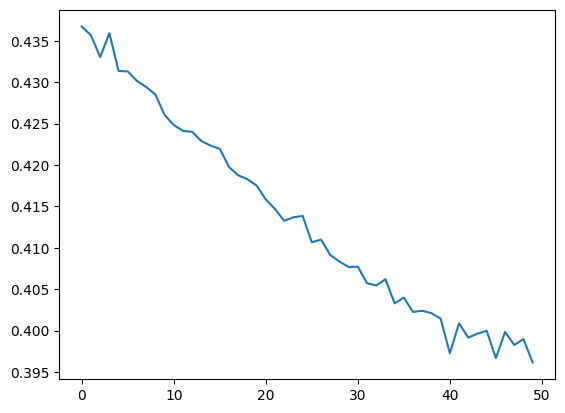

In [18]:
plt.plot(lossi)

In [ ]:
X_val = X_val.to('cuda')
y_val = y_val.to('cuda')

model.eval()

with torch.no_grad():
    val_logits = model(X_val)
    val_loss = criterion(val_logits, y_val)
    print(f"Validation Loss = {val_loss.item()}")

Validation Loss = 0.3579352796077728


trainidation Loss = 0.39382436871528625
              precision    recall  f1-score   support

  No Smoking       0.98      0.97      0.98      4444
     Smoking       0.17      0.31      0.22        99

    accuracy                           0.95      4543
   macro avg       0.58      0.64      0.60      4543
weighted avg       0.97      0.95      0.96      4543



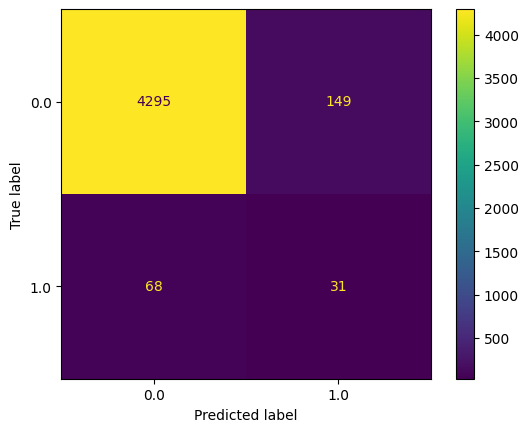

In [20]:
X_train = X_train.to('cuda')
y_train = y_train.to('cuda')

model.eval()

with torch.no_grad():
    train_logits = model(X_train)
    train_loss = criterion(train_logits, y_train)
    print(f"trainidation Loss = {train_loss.item()}")

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = train_logits.sigmoid().round().cpu().flatten()
y_true = y_train.cpu().flatten()

print(classification_report(y_true, y_pred, target_names=['No Smoking', 'Smoking']))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

              precision    recall  f1-score   support

  No Smoking       0.98      0.97      0.98      1484
     Smoking       0.13      0.23      0.17        30

    accuracy                           0.95      1514
   macro avg       0.56      0.60      0.57      1514
weighted avg       0.97      0.95      0.96      1514



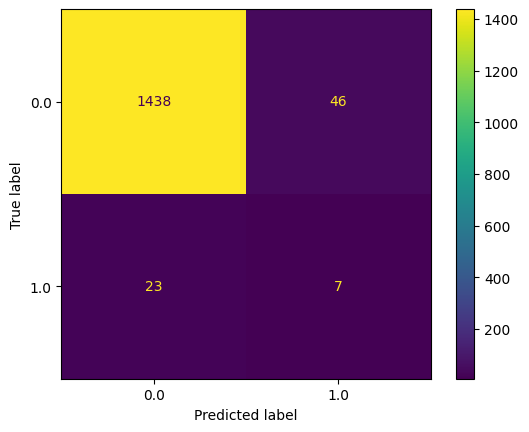

In [16]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = val_logits.sigmoid().round().cpu().flatten()
y_true = y_val.cpu().flatten()

print(classification_report(y_true, y_pred, target_names=['No Smoking', 'Smoking']))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)